# Comparing the Efficacy of the Exemplar and Prototype Models for Predicting Color Categorization Across Languages

COG260 Research Project 2023

Gabriel Guralnick and Elizabeth Li

## Demos for analyzing World Color Survey (WCS)

COG 260: Data, Computation, and The Mind (Yang Xu)

Data source: http://www1.icsi.berkeley.edu/wcs/data.html

______________________________________________

Import helper function file for WCS data analysis.

In [1]:
from wcs_helper_functions import *

Import relevant Python libraries.

In [2]:
import numpy as np
from scipy import stats
from random import random
from collections import defaultdict, Counter
%matplotlib inline

### Demo 1: Import stimulus (color chip) information in [Munsell space](https://en.wikipedia.org/wiki/Munsell_color_system)

> Stimuli were 330 color chips in Munsell space, each defined along lightness and hue dimensions.

> Each color chip has an index _(from 1 to 330)_ and a coordinate (lightness *(alphabet)*, hue *(integer)*).

In the following section, you will learn how to convert from **(a) index to coordinate** and **(b) coordinate to index**.

______________________________________________

Load chip information in Munsell space. 

`munsellInfo` is a 2-element tuple with dictionary elements.

In [3]:
munsellInfo = readChipData('./WCS_data_core/chip.txt')
munsellInfo

({'E29': 1,
  'C23': 2,
  'F4': 3,
  'I36': 4,
  'C20': 5,
  'C6': 6,
  'E15': 7,
  'H40': 8,
  'G6': 9,
  'I30': 10,
  'I22': 11,
  'C11': 12,
  'I18': 13,
  'I26': 14,
  'C35': 15,
  'C0': 16,
  'E3': 17,
  'I11': 18,
  'E27': 19,
  'F16': 20,
  'E39': 21,
  'B10': 22,
  'F34': 23,
  'H10': 24,
  'G24': 25,
  'H30': 26,
  'B5': 27,
  'E38': 28,
  'D18': 29,
  'F6': 30,
  'C24': 31,
  'E36': 32,
  'D15': 33,
  'F28': 34,
  'D3': 35,
  'I20': 36,
  'E30': 37,
  'G39': 38,
  'G16': 39,
  'E25': 40,
  'H3': 41,
  'E10': 42,
  'I29': 43,
  'B40': 44,
  'E17': 45,
  'F0': 46,
  'I17': 47,
  'E8': 48,
  'D25': 49,
  'I35': 50,
  'H8': 51,
  'B16': 52,
  'H39': 53,
  'G15': 54,
  'E24': 55,
  'C4': 56,
  'H24': 57,
  'F10': 58,
  'C34': 59,
  'I25': 60,
  'H2': 61,
  'E32': 62,
  'D1': 63,
  'G29': 64,
  'F39': 65,
  'B8': 66,
  'C18': 67,
  'E37': 68,
  'G12': 69,
  'C32': 70,
  'I1': 71,
  'G19': 72,
  'H34': 73,
  'C26': 74,
  'I16': 75,
  'F5': 76,
  'F24': 77,
  'C36': 78,
  'H0': 79,
 

#### (a) Index &rarr; Coordinate

Access the second dictionary in `munsellInfo`.

In [4]:
indexCoord = munsellInfo[1]

`indexCoord` is a dictionary with **index _(key)_ &rarr; coordinate _(value)_** pairs. For example, to retrieve the Munsell coordinate _(lightness, hue)_ for chip with numerical index 1:

In [5]:
print(indexCoord[1])

('E', '29')


You can also uncomment the following to display full stimulus information (long).

In [6]:
# print(indexCoord)

#### (b) Coordinate &rarr; Index

Access the first dictionary in `munsellInfo`.

In [7]:
coordIndex = munsellInfo[0]

`coordIndex` is a dictionary with **coordinate _(key)_ &rarr; index _(value)_** pairs. For example, to access numerical index for the color chip at Munsell coordinate _(D, 11)_:

In [8]:
print(coordIndex['D11'])

258


You can also uncomment the following to display full stimulus information (long).

In [9]:
# print(coordIndex)

### Demo 2: Import stimulus information in [CIELAB space](https://en.wikipedia.org/wiki/Lab_color_space)

> Each of the 330 stimuli can also be mapped to the 3D CIELAB space, where the dimensions are `l` _(lightness)_, `a`, & `b` _(color opponency)_.

> CIELAB Coordinates have a **one-to-one** correspondence with Munsell index, which ranges from 1 to 330.

______________________________________________

Load chip coordinates in CIELAB. 

`cielabCoord` is a dictionary with **index _(key)_ &rarr; CIELAB Coordinate _(value)_** pairs.

In [10]:
cielabCoord = readClabData('./WCS_data_core/cnum-vhcm-lab-new.txt')

For example, to obtain the CIELAB coordinates for chip with numerical index 1:

In [11]:
print(cielabCoord[1])

('61.70', '-4.52', '-39.18')


### Demo 3: Import color naming data
    
> Each of the 330 color chips was named by speakers of 110 different languages.

______________________________________________

Load naming data. 

`namingData` is a hierarchical dictionary organized as follows:

**language _(1 - 110)_ &rarr; speaker _(1 - *range varies per language*)_ &rarr; chip index _(1 - 330)_ &rarr; color term**

In [12]:
namingData = readNamingData('./WCS_data_core/term.txt')

For example, to obtain naming data from language 1 and speaker 1 for all 330 color chips:

In [13]:
namingData[1][1]; # remove semicolon to see data in full

For example, to see how many speakers language 1 has:

In [14]:
len(namingData[1])

25

### Demo 4: Import color foci data
    
> Apart from naming the color chips, each speaker also pointed to foci color chips for each color term they had used.

> **Note**: A single color term may have multiple foci locations.

______________________________________________

Load foci data. 

`fociData` is a hierarchical dictionary organized as follows: 

**language _(1 - 110)_ &rarr; speaker _(1 - *range varies per language*)_ &rarr; color term &rarr; foci coordinates**

In [15]:
fociData = readFociData('./WCS_data_core/foci-exp.txt');

For example, to obtain foci data for language 1 and speaker 1, where each entry shows foci locations for given term: 

In [16]:
fociData[1][1]

{'LF': ['A:0'],
 'WK': ['D:9', 'D:10', 'D:11', 'D:12'],
 'F': ['D:25'],
 'LB': ['J:0'],
 'G': ['F:17'],
 'LE': ['F:1', 'F:2', 'F:3', 'G:1', 'G:2', 'G:3']}

In the above example, foci for term 'LF' is located at coordinate _(A, 0)_ in the Munsell chart.

### Demo 5: Import speaker demographic information

> Most speakers' age _(integer)_ and gender _(M/F)_ information was recorded.

______________________________________________

Load speaker information.

`speakerInfo` is a hierarchical dictionary organized as follows:

**language &rarr; speaker &rarr; (age, gender)**

In [17]:
speakerInfo = readSpeakerData('./WCS_data_core/spkr-lsas.txt')

For example, uncomment the following line to access _(age, gender)_ information for all speakers from language 1:

In [18]:
# speakerInfo[1]

For example, uncomment the following line to access _(age, gender)_ information for speaker 1 from language 1:

In [19]:
# speakerInfo[1][1]

### Demo 6: Visualize color naming from an individual speaker

> Naming patterns from a speaker can be visualized in the stimulus palette _(Munsell space)_.

______________________________________________

Extract an example speaker datum from an example language.

In [20]:
lg61_spk5 = namingData[61][5]

Extract color terms used by that speaker.

In [21]:
terms = lg61_spk5.values()
# terms

Encode the color terms into random numbers (for plotting purposes).

In [22]:
encoded_terms = map_array_to(terms, generate_random_values(terms))

Visualize the color naming pattern for that speaker&mdash;each color patch corresponds to extension of a color term. Color scheme is randomized, but the partition of the color space is invariant.

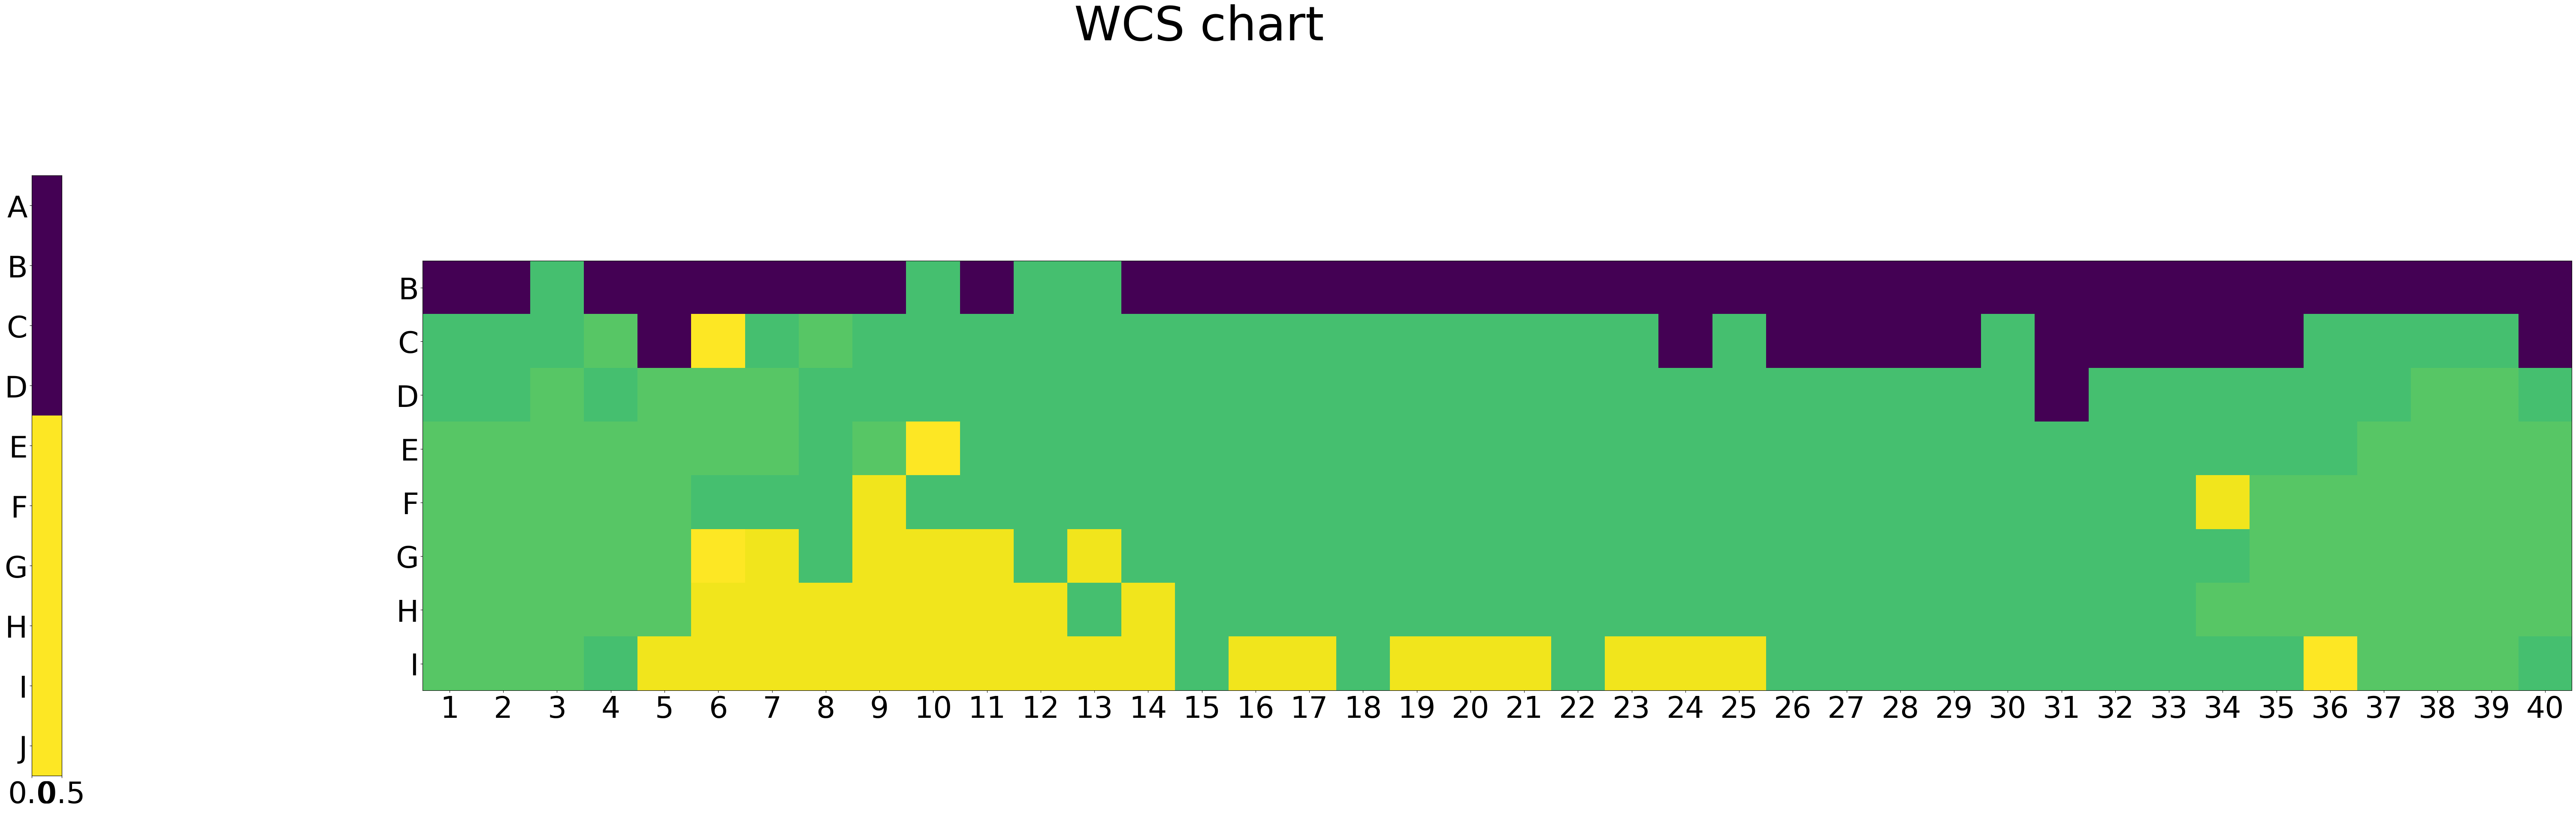

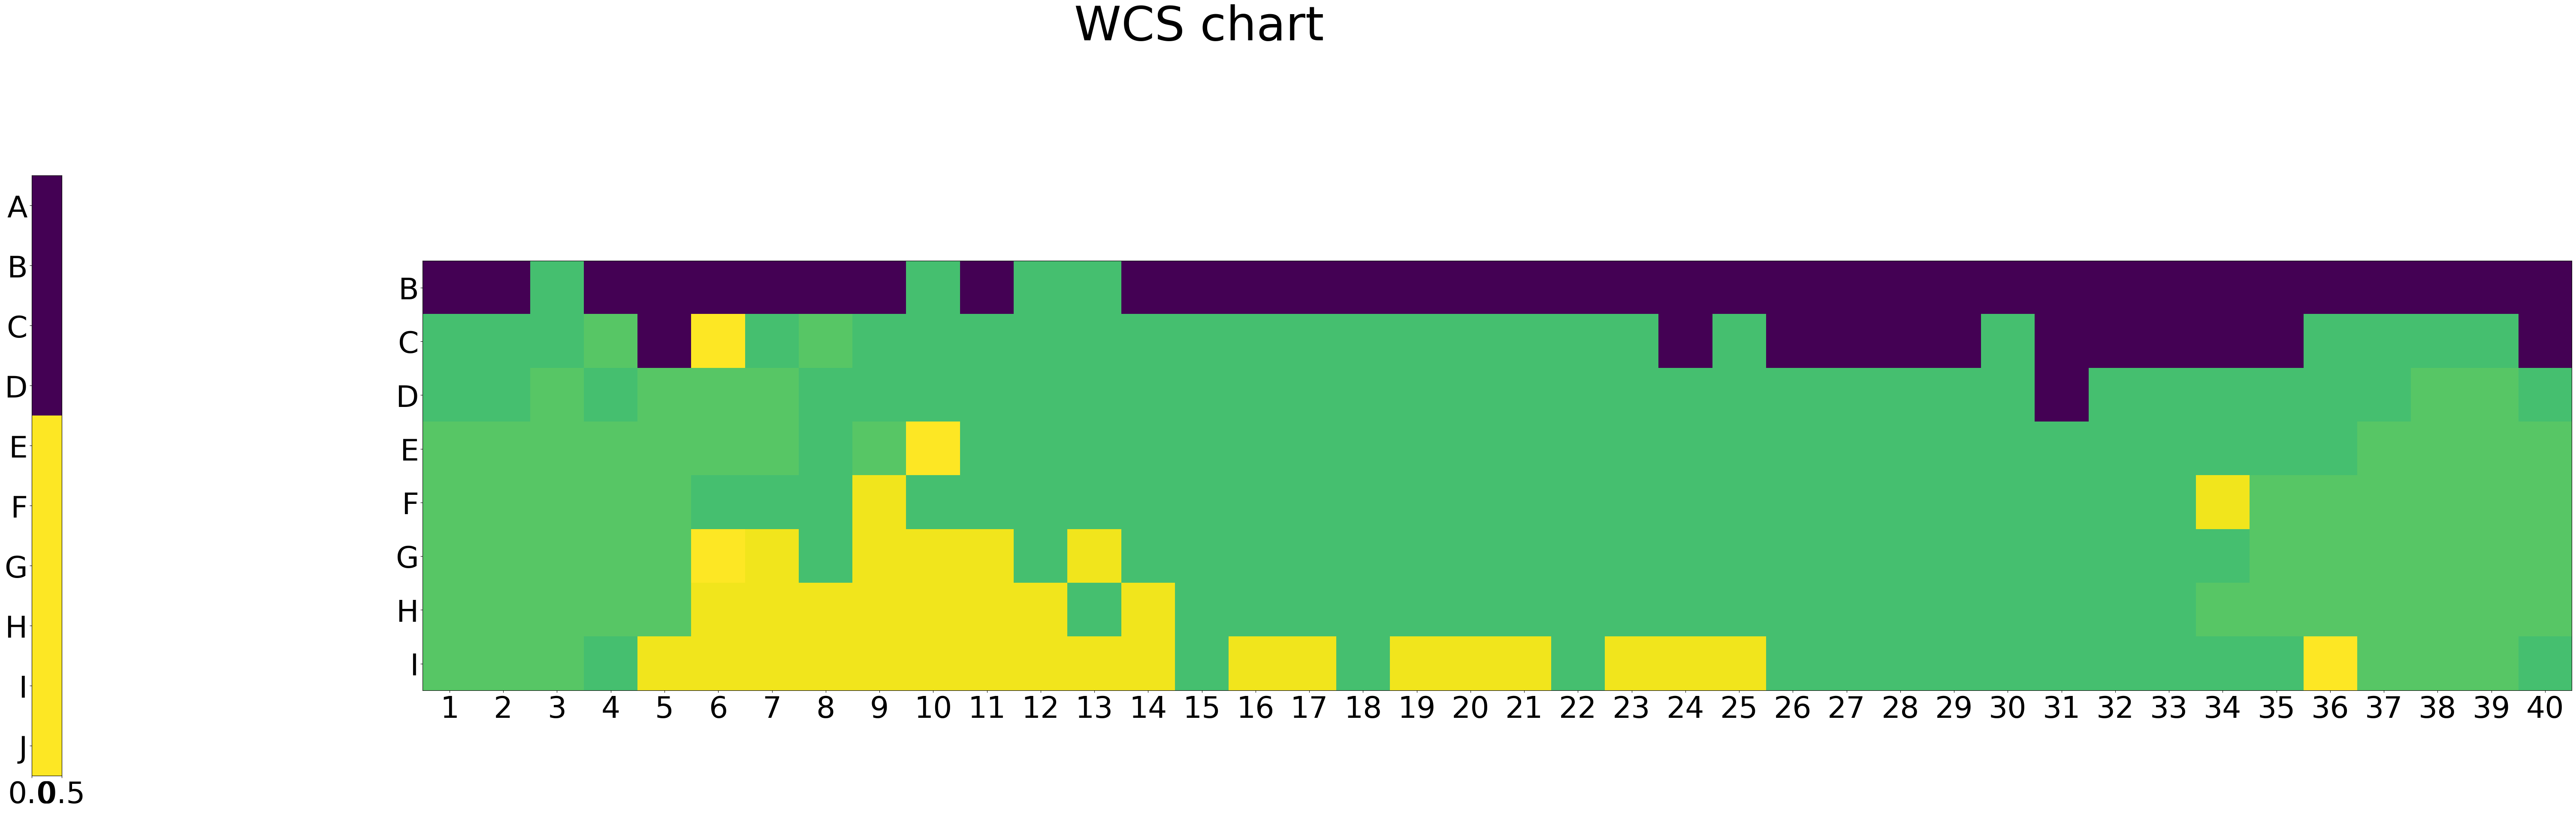

In [23]:
plotValues(encoded_terms)

**Note**: `plotValues()` is a generic function for visualizing various kinds of information on the chart, suited to needs.

Now you are in a position to start exploring this data set - enjoy!

## Our Analysis

### Qualitative Analysis - Foci Contour Plots

#### Empirical Color Foci

Our first goal is to reproduce the following diagram from Abbott, Griffiths, & Regier (2016) showing the empirical color foci from the WCS dataset.

![image.png](images/empirical-contours.png)

This graph shows the color chips that were most commonly identified as the focus of some color term across all languages. The clustering of the contours suggests a set of universal basic colors at each of the peaks in the contour plot.

Part of our evaluation of the prototype and exemplar models will be a qualitative comparison of their predicted color foci plots to this empirical one.

In [24]:
# fociData

In [25]:
overallFociCount = {}
for language in fociData:
    speaker_data = fociData[language]
    for speaker in speaker_data:
        colors = speaker_data[speaker]
        for color in colors:
            colorFoci = colors[color]
            for focus in colorFoci:
                focusIndex = coordIndex[focus.replace(':', '')]
                if focusIndex in overallFociCount:
                    overallFociCount[focusIndex] += 1
                else:
                    overallFociCount[focusIndex] = 1


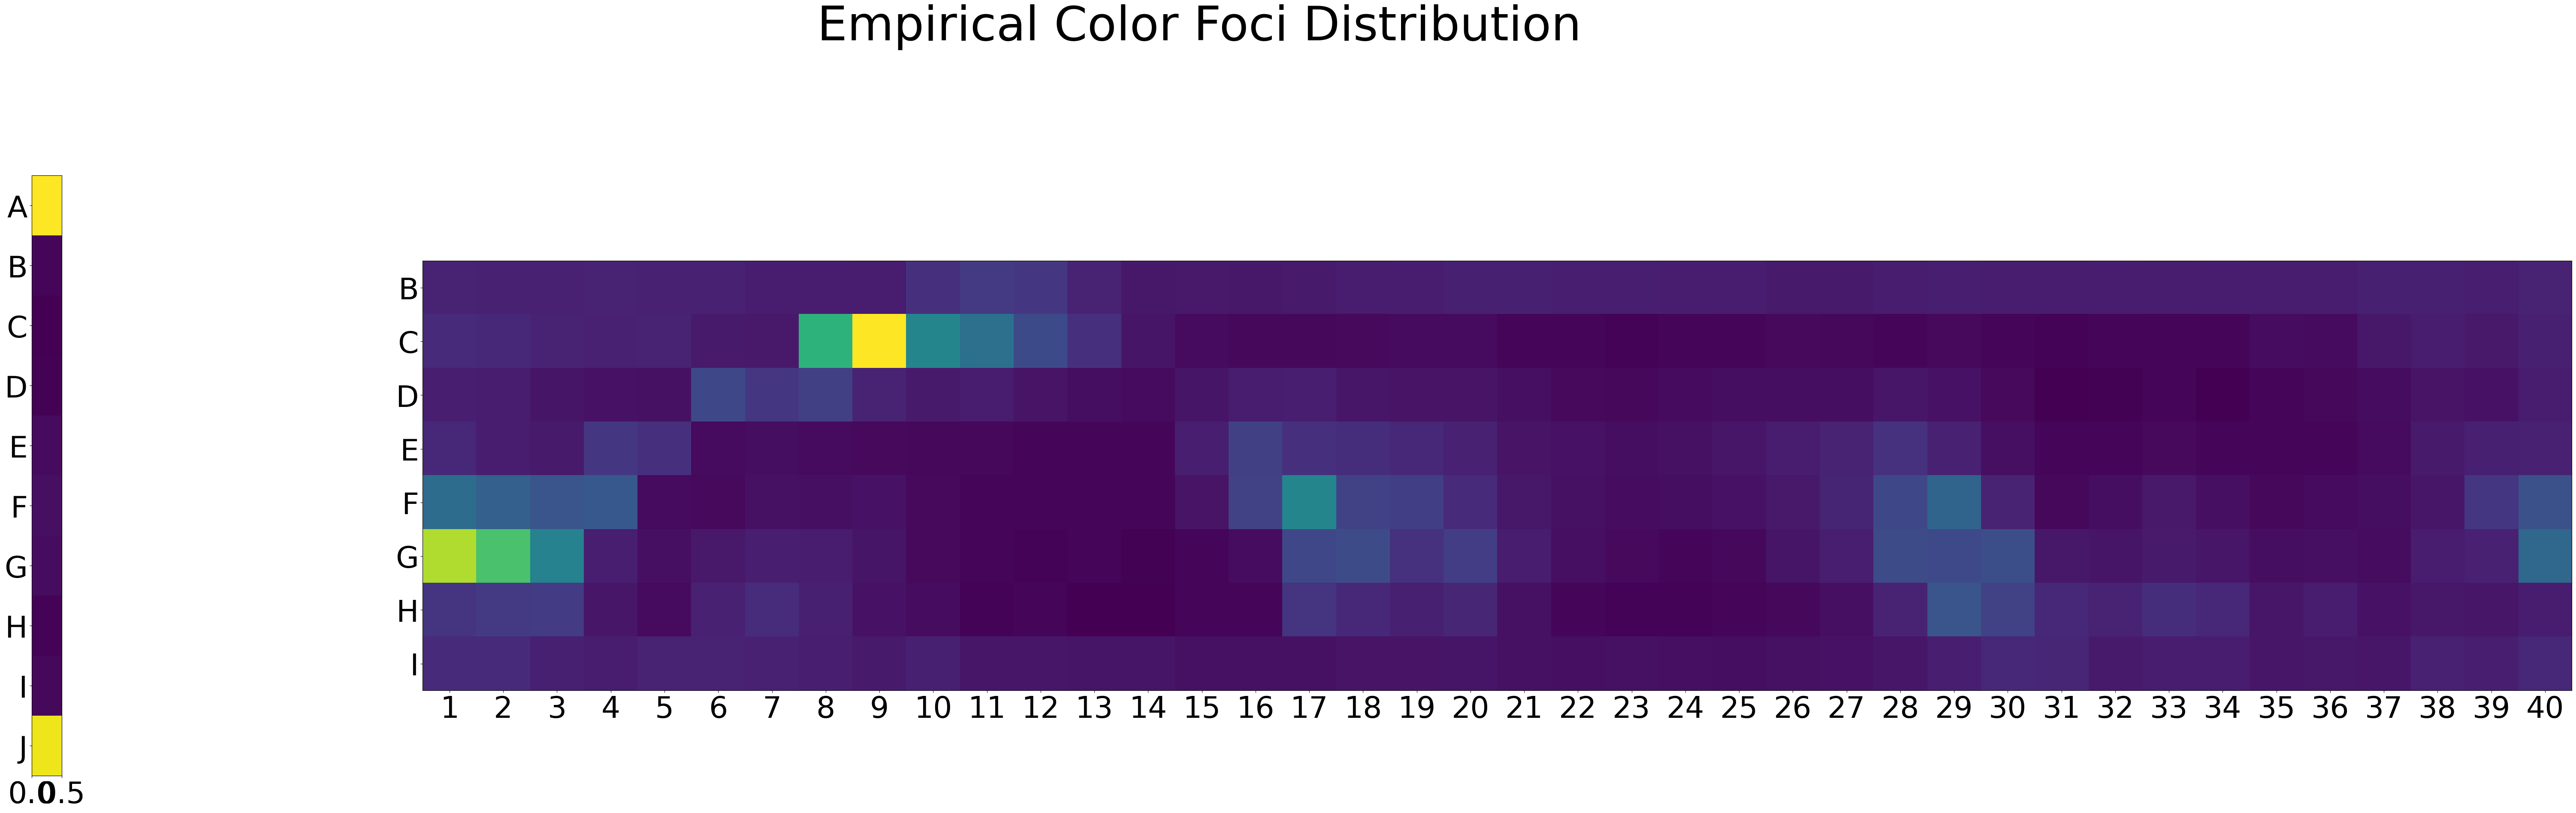

In [26]:
fig = plotValues(map_array_to(indexCoord, overallFociCount), title='Empirical Color Foci Distribution')

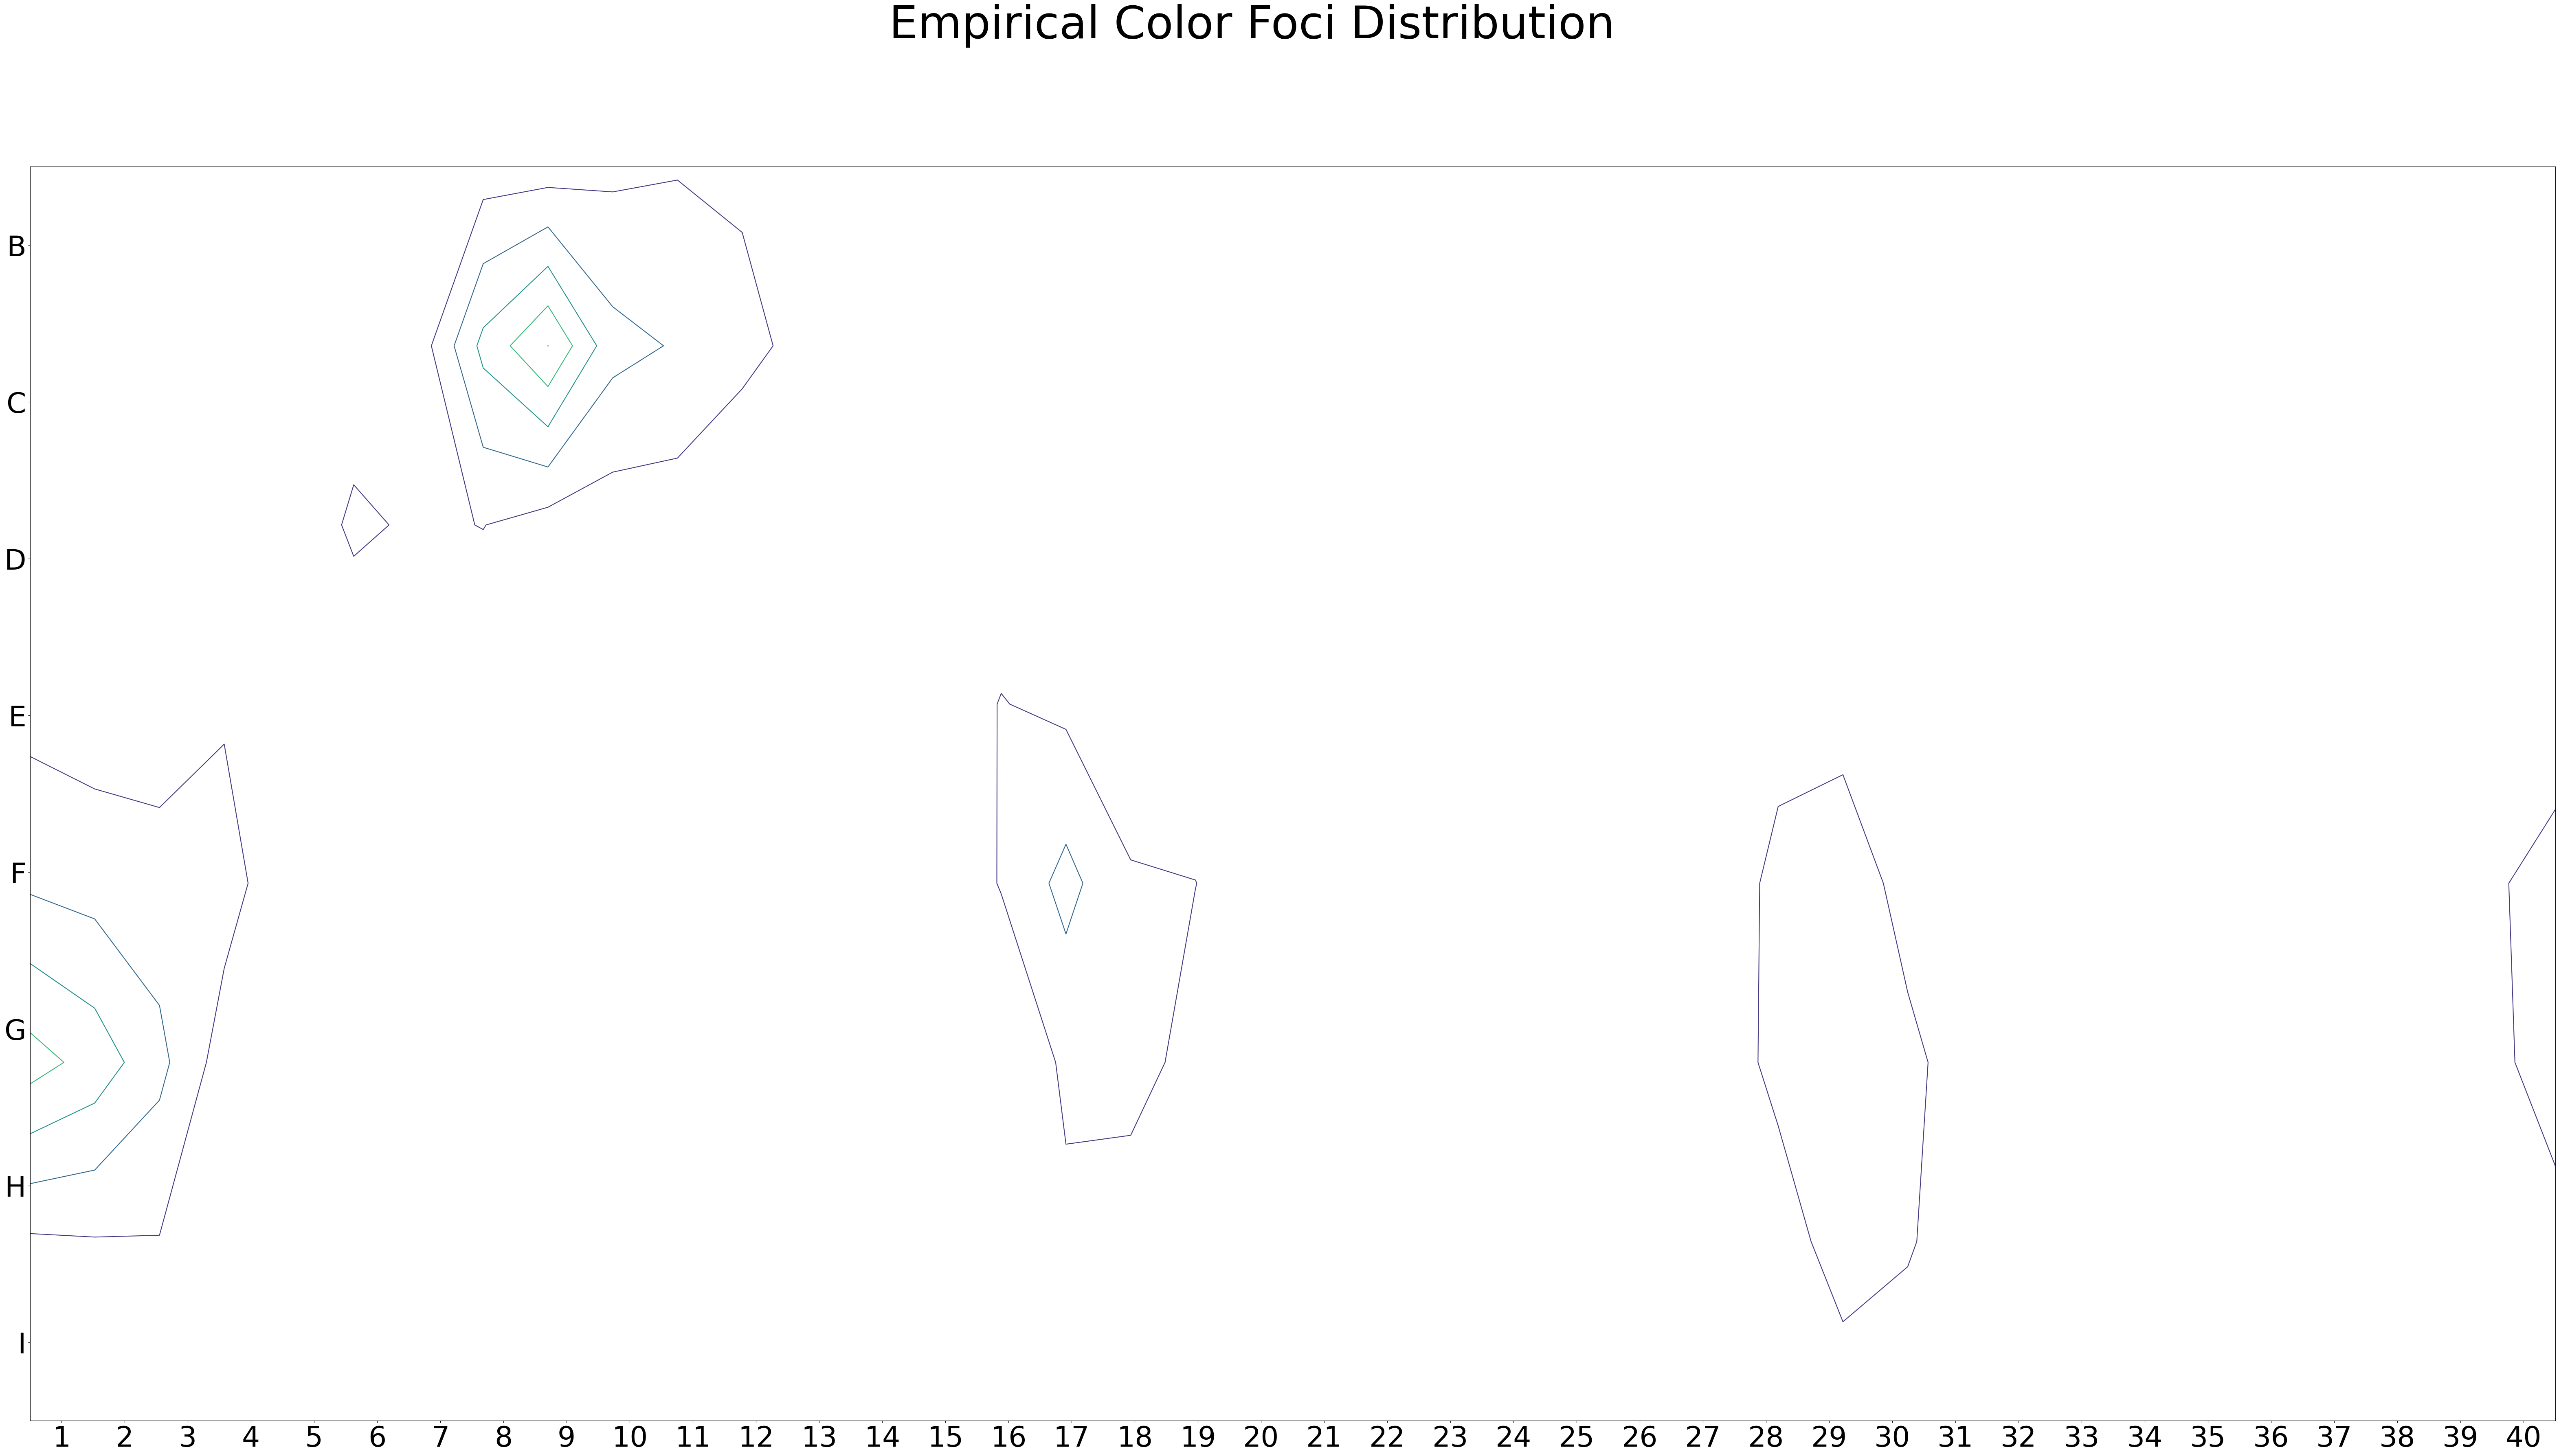

In [27]:
fig = plotValuesContour(map_array_to(indexCoord, overallFociCount), title='Empirical Color Foci Distribution')

#### Prototype Model

![image.png](images/prototype-contours.png)

In [28]:
# for each speaker and language, map color term -> chip
# format: (language, speaker) -> color term -> chips (array of values)
speaker_terms = {}

for language in namingData:
    # speaker_terms[language] = {}
    for speaker in namingData[language]:
        # speaker_terms[language][speaker] = {}
        speaker_terms[(language, speaker)] = {}
        for chip in namingData[language][speaker]:
            term = namingData[language][speaker][chip]
            if term not in speaker_terms[(language, speaker)]:
                speaker_terms[(language, speaker)][term] = []
            speaker_terms[(language, speaker)][term].append(chip)

# print(speaker_terms[(1, 1)])

In [29]:
# now get the centroid of each color term for each language + speaker
# format: (language, speaker) -> color term -> CIELAB prototype coords
speaker_prototype = {}
for lang_speak in speaker_terms:
    speaker_prototype[lang_speak] = {}
    for color_term in speaker_terms[lang_speak]:
        chips = speaker_terms[lang_speak][color_term]
        # for each chip, get their cielab coordinates
        coords = np.array([tuple(map(float, cielabCoord[chip])) for chip in chips])
        # calculate centroid
        centroid = np.mean(coords, axis=0)
        speaker_prototype[lang_speak][color_term] = centroid

In [30]:
def compute_similarity(target, category_chips, c=0.001):
    # Vectorized computation of Euclidean distance between target and all CIELAB coordinates
    distances = np.linalg.norm(category_chips - target, axis=1)

    # Calculate the similarity scores
    similarities = np.exp(-c * distances**2)

    return similarities

cielab_array = np.array([tuple(map(float, coords)) for coords in cielabCoord.values()])

In [31]:
# now for each colour term, we'll try to predict foci coordinates (essentially recreating fociData)
prototype_predicted = {}
for language in fociData:
    for speaker in fociData[language]:
        if (language, speaker) not in speaker_prototype:
            continue
        for color_term in fociData[language][speaker]:
            if color_term not in speaker_prototype[(language, speaker)]:
                continue
            n = len(fociData[language][speaker][color_term])
            # predict foci coordinate -- compare speaker's prototype of this color term w/ CIELAB coords to get
            # the chip that's closest to the prototype
            prototype = np.array(speaker_prototype[(language, speaker)][color_term])

            # compute similarity of prototype w/ all cielab coords to get coord closest to prototype
            similarities = compute_similarity(prototype, cielab_array)

            chip_num_with_sim = list(zip(cielabCoord.keys(), similarities))
            chip_num_with_sim.sort(key=lambda x: x[1], reverse=True)

            # Get indices of the top n most similar chips
            # more similar = larger score
            top_n_indices = [chip_num_with_sim[i][0] for i in range(n)]

            # Update the predicted count for each of the top n chips
            for idx in top_n_indices:
                if idx not in prototype_predicted:
                    prototype_predicted[idx] = 0
                prototype_predicted[idx] += 1
            

In [32]:
print(len(prototype_predicted))
print(sum(overallFociCount.values()), sum(prototype_predicted.values()))

330
30991 29358


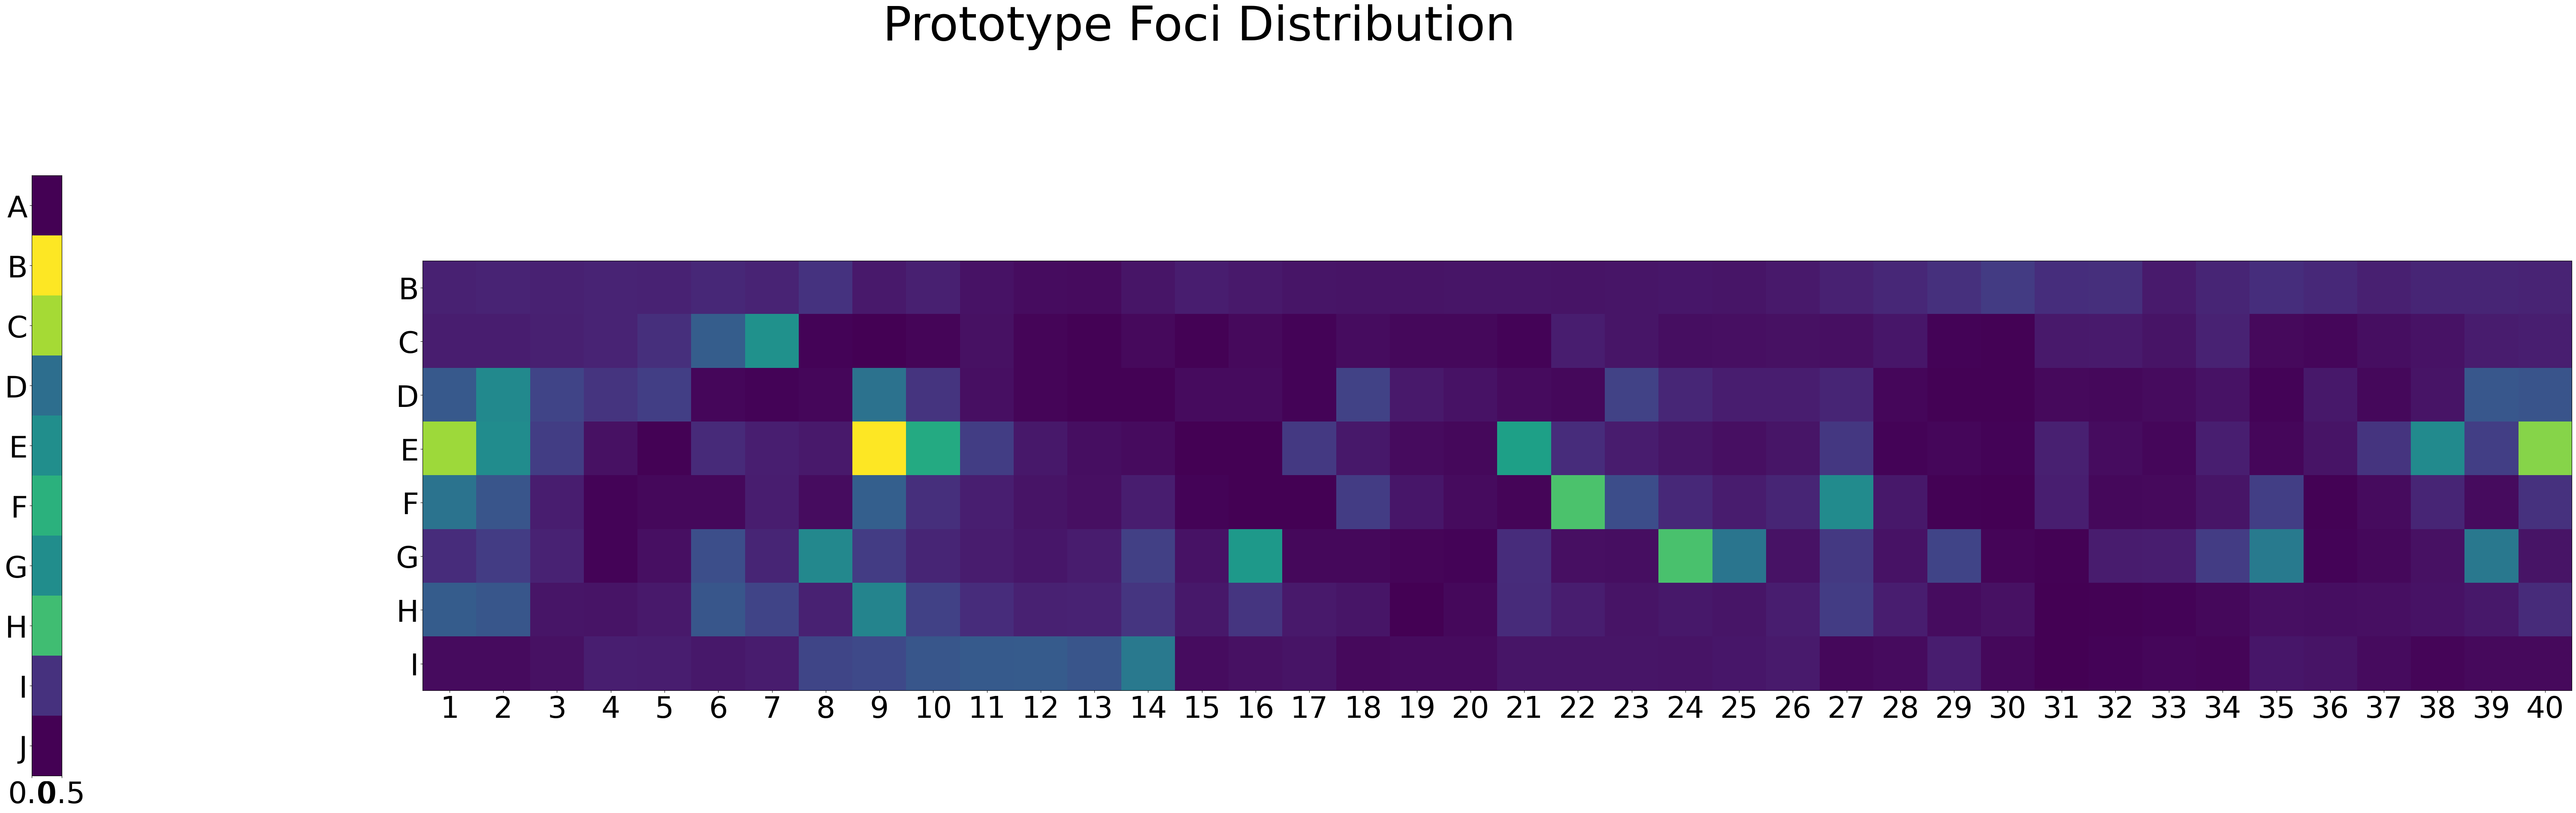

In [33]:
fig = plotValues(map_array_to(indexCoord, prototype_predicted), title='Prototype Foci Distribution')

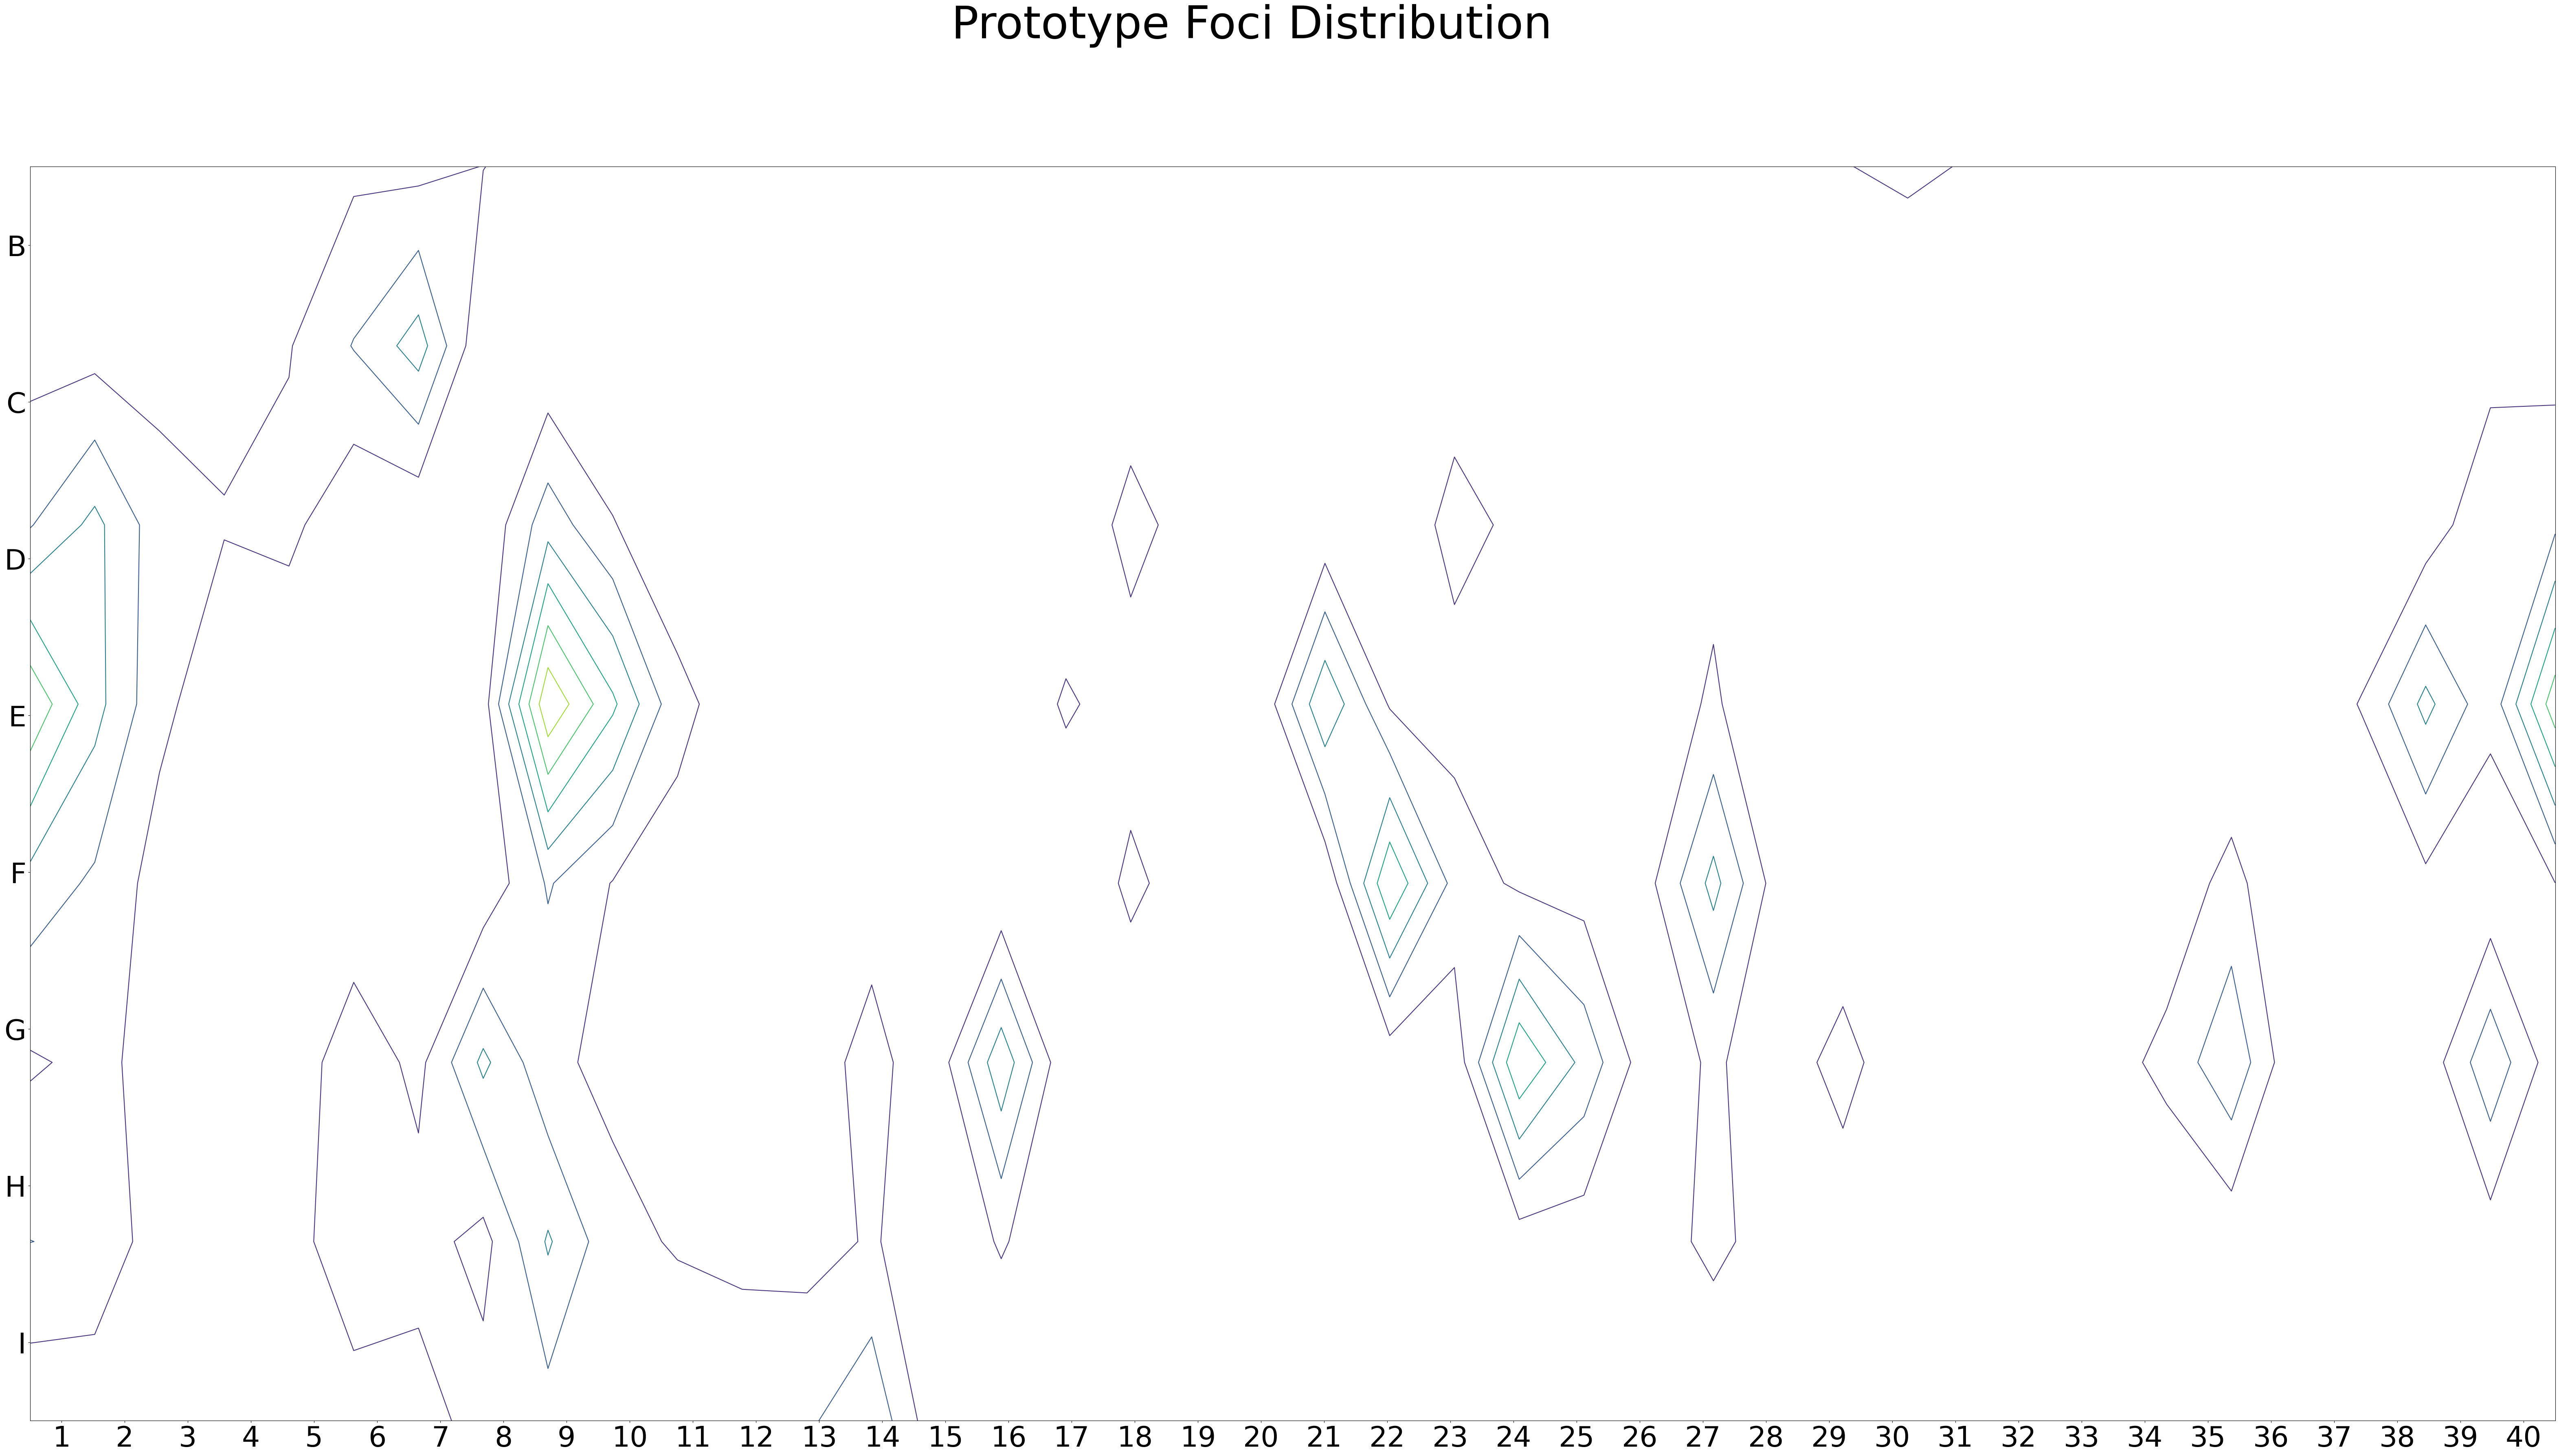

In [34]:
fig = plotValuesContour(map_array_to(indexCoord, prototype_predicted), title='Prototype Foci Distribution')

#### Exemplar Model

In [35]:
def exemplar_scores(all_chips_cielab, category_chips_cielab):
    """Sort all chips based on their exemplar scores for the category."""

    scores = []
    for chip in all_chips_cielab:
        exemplar_score = np.sum(compute_similarity(chip, category_chips_cielab))
        scores.append(exemplar_score)
    
    return scores


In [36]:
exemplar_predicted = {}
for language in fociData:
    language_data = fociData[language]
    for speaker in language_data:
        if (language, speaker) not in speaker_terms:
            continue
        speaker_data = language_data[speaker]
        for colour in speaker_data:
            fociInfo = speaker_data[colour]
            n = len(fociInfo)

            if colour not in speaker_terms[(language, speaker)]:
                continue
            category_chips = speaker_terms[(language,speaker)][colour]

            # Get the CIELAB coordinates for all chips in the category
            category_chips_cielab = np.array([tuple(map(float, cielabCoord[chip])) for chip in category_chips])

            # Sort all chips based on their exemplar scores for the category
            scores = exemplar_scores(cielab_array, category_chips_cielab)

            chip_num_with_score = list(zip(cielabCoord.keys(), scores))
            chip_num_with_score.sort(key=lambda x: x[1], reverse=True)

            top_n_indices = [chip_num_with_score[i][0] for i in range(n)]

            # Update the predicted count for each of the top n chips
            for idx in top_n_indices:
                if idx not in exemplar_predicted:
                    exemplar_predicted[idx] = 0
                exemplar_predicted[idx] += 1

In [37]:
# sanity check to see if the same number of predictions are made as the number of foci in the empirical data
print(len(overallFociCount), len(exemplar_predicted))
print(sum(overallFociCount.values()), sum(exemplar_predicted.values()))


330 330
30991 29358


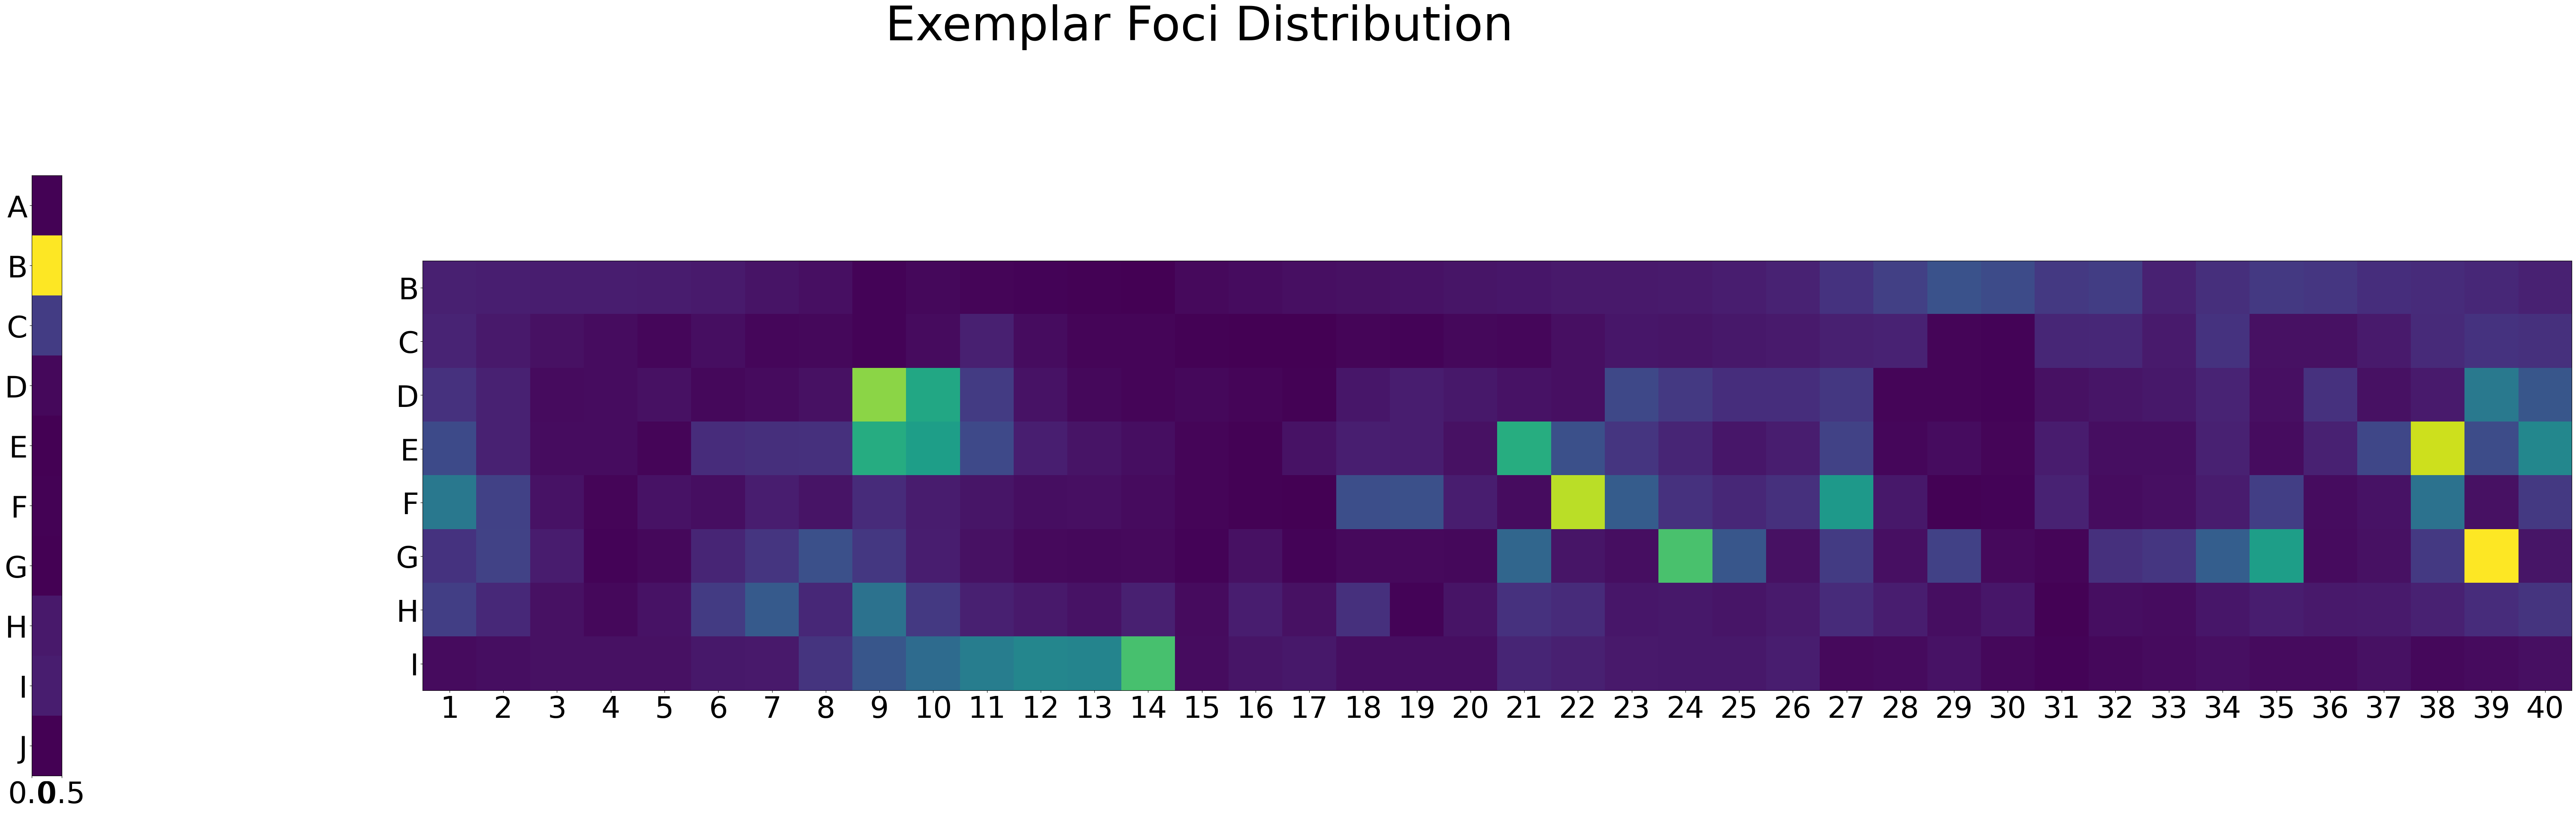

In [38]:
fig = plotValues(map_array_to(indexCoord, exemplar_predicted), title='Exemplar Foci Distribution')

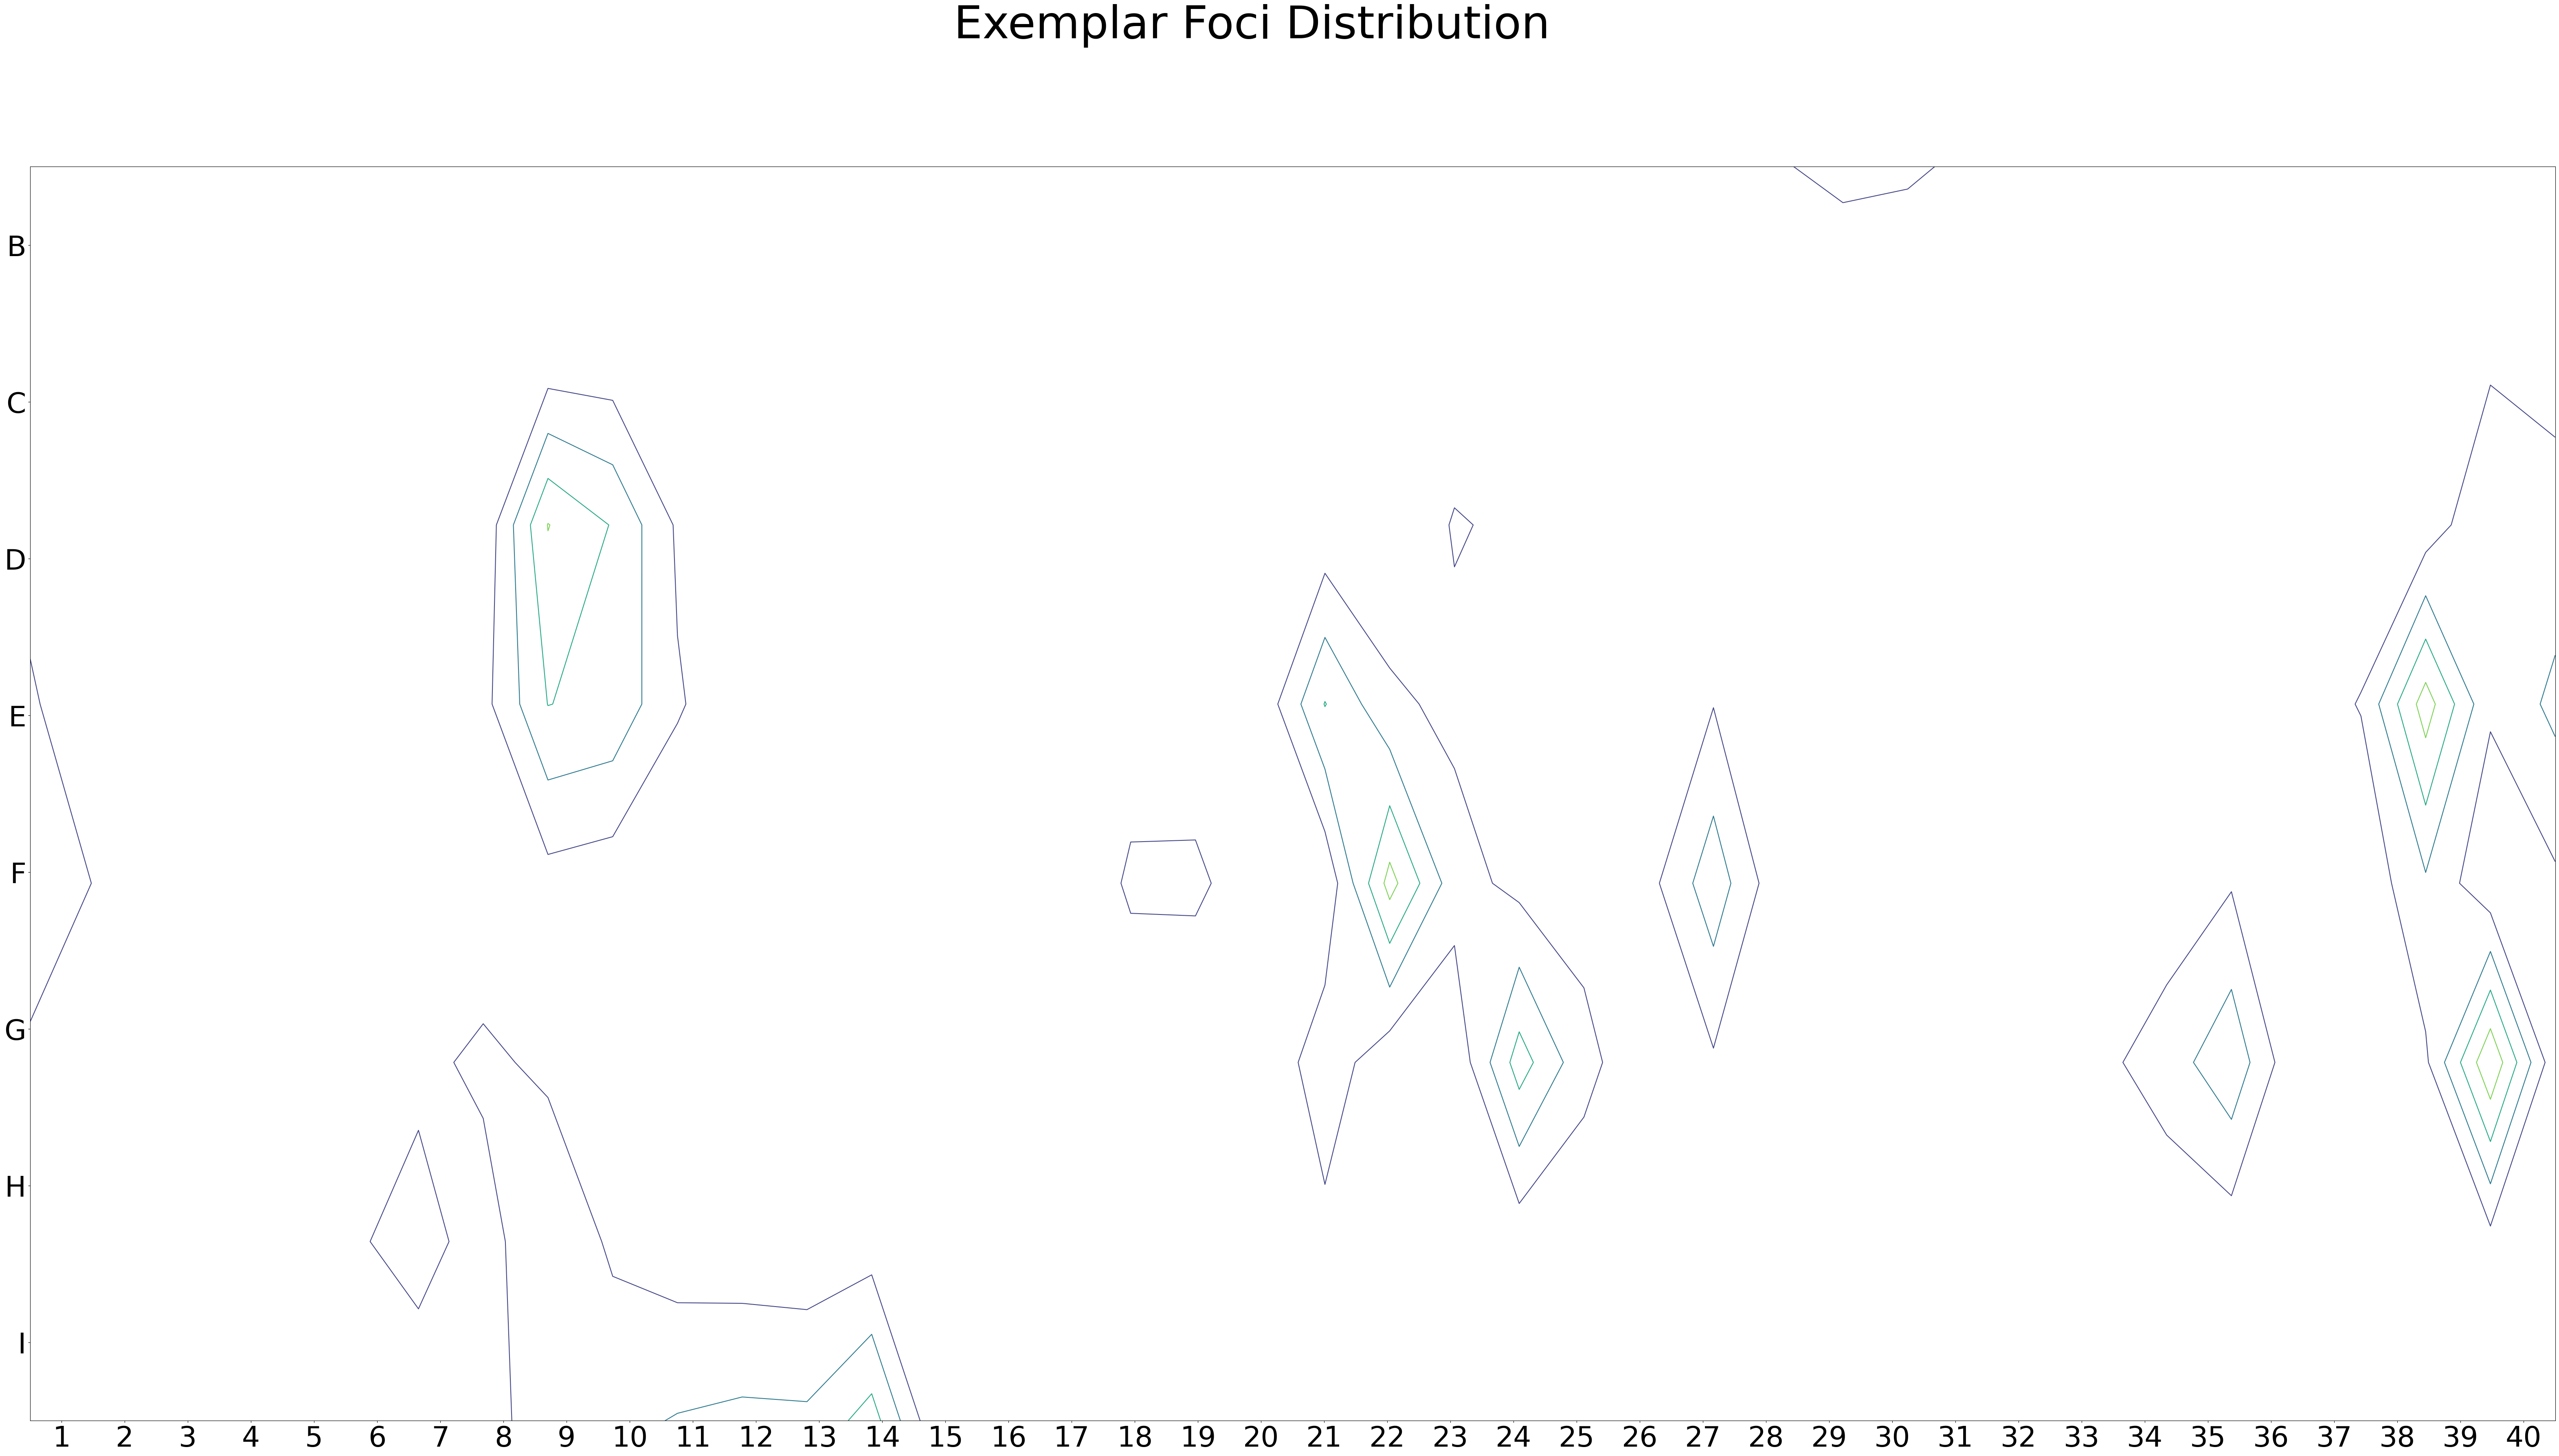

In [39]:
fig = plotValuesContour(map_array_to(indexCoord, exemplar_predicted), title='Exemplar Foci Distribution')

### Quantitative Analysis

In [75]:
def create_histogram(distribution, num_chips=330):
    histogram = np.zeros(num_chips)
    for chip_index in distribution:
        histogram[int(chip_index) - 1] = distribution[int(chip_index)]  # Assuming chip_index starts from 1

    # normalization
    # max_value = np.max(histogram)
    # min_value = np.min(histogram)
    # if max_value > min_value:
    #     histogram = (histogram - min_value) / (max_value - min_value)

    total = np.sum(histogram)
    if total > 0:
        histogram = histogram / total
    
    return histogram

# Assuming we have 330 chips
hist_prototype = create_histogram(prototype_predicted, 330)
hist_wcs_focus = create_histogram(overallFociCount, 330)
hist_exemplar = create_histogram(exemplar_predicted, 330)
print(hist_prototype)

# print([int(x) for x in hist_prototype].sort() == list(prototype_predicted.values()).sort())
# print(exemplar_predicted.keys())

[4.52993240e-04 1.35897972e-03 2.09073803e-04 1.28928845e-03
 5.57530141e-04 7.07366367e-03 6.96912677e-05 2.92703324e-03
 5.74952958e-03 5.57530141e-04 1.32413409e-03 1.04536902e-03
 6.27221409e-04 1.74228169e-03 6.27221409e-04 3.29291240e-02
 4.32085860e-03 6.76005297e-03 3.90271099e-03 0.00000000e+00
 4.46024113e-03 2.05589240e-03 1.35897972e-03 4.59962367e-03
 1.70395149e-02 1.08021465e-03 2.26496620e-03 1.13945223e-02
 4.70416057e-03 5.22684508e-04 8.71140846e-04 1.25444282e-03
 6.62067043e-04 1.49836226e-03 4.91323437e-03 7.31758311e-04
 2.09073803e-04 9.51285804e-03 1.28928845e-02 1.01052338e-03
 1.32413409e-03 1.45654749e-02 1.88166423e-03 2.40434874e-03
 3.93755662e-03 2.46707088e-02 1.21959718e-03 1.63774479e-03
 1.91650986e-03 1.42867099e-03 2.19527493e-03 1.60289916e-03
 1.56805352e-03 1.18475155e-03 1.32413409e-03 2.36950310e-03
 1.49836226e-03 3.24064395e-03 2.29981183e-03 1.42867099e-03
 6.37675099e-03 8.01449578e-04 6.65551606e-03 4.91323437e-03
 6.96912677e-04 3.484563

In [76]:
sum(hist_exemplar)

1.0000000000000002

In [77]:
hist_wcs_focus

array([2.61651056e-03, 3.03363543e-04, 7.65992947e-03, 1.85810170e-03,
       7.96329301e-04, 2.00978347e-03, 2.35106746e-03, 2.08562436e-03,
       1.93394259e-03, 3.07155588e-03, 1.17553373e-03, 1.03143605e-02,
       1.51681772e-03, 1.28929506e-03, 9.48011073e-04, 1.97186303e-03,
       2.04770392e-03, 1.70641993e-03, 2.69235145e-03, 5.42262334e-03,
       2.42690835e-03, 3.90580562e-03, 1.13761329e-03, 9.48011073e-04,
       4.55045315e-04, 5.49846422e-03, 2.57859012e-03, 1.97186303e-03,
       1.66849949e-03, 7.20488415e-04, 3.79204429e-04, 5.30886201e-04,
       1.63057905e-03, 6.06727087e-03, 1.59265860e-03, 1.55473816e-03,
       1.13761329e-03, 2.61651056e-03, 9.48011073e-04, 1.66849949e-03,
       4.89173714e-03, 6.44647529e-04, 2.35106746e-03, 2.76819233e-03,
       3.90580562e-03, 5.53638466e-03, 1.28929506e-03, 8.72170187e-04,
       1.02385196e-03, 1.70641993e-03, 2.46482879e-03, 1.85810170e-03,
       1.66849949e-03, 3.79204429e-04, 1.28929506e-03, 2.54066968e-03,
      

In [42]:
max(hist_wcs_focus)

0.07815172146752283

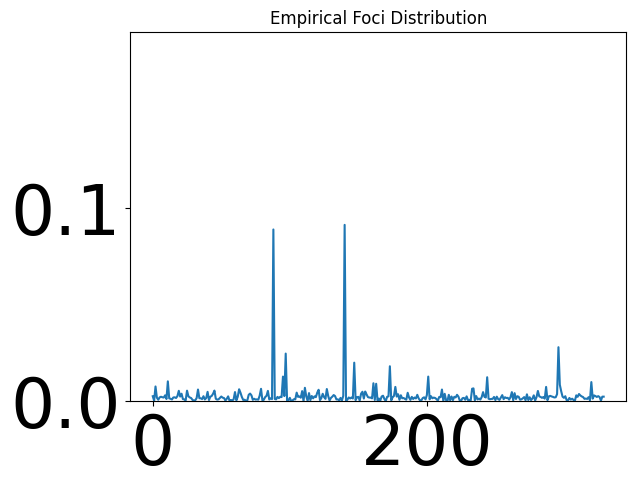

In [78]:
plt.figure()
bins = np.linspace(0, 329, 330)
plt.plot(bins, hist_wcs_focus)
plt.ylim(0, max(hist_wcs_focus) + 0.1)
plt.title('Empirical Foci Distribution')
plt.show()

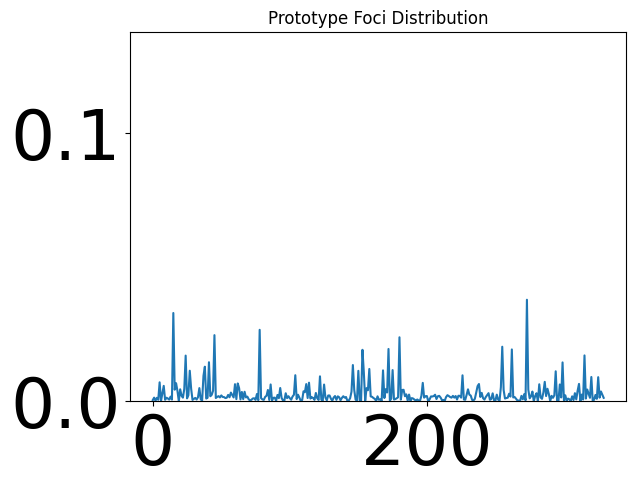

In [79]:
plt.figure()
bins = np.linspace(0, 329, 330)
plt.plot(bins, hist_prototype)
plt.ylim(0, max(hist_prototype) + 0.1)
plt.title('Prototype Foci Distribution')
plt.show()

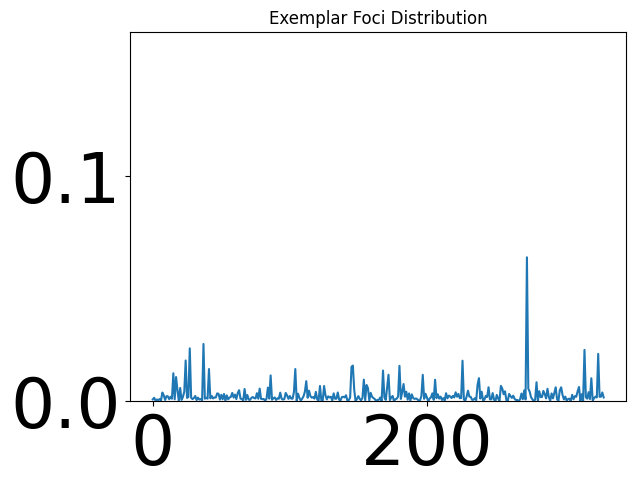

In [80]:
plt.figure()
bins = np.linspace(0, 329, 330)
plt.plot(bins, hist_exemplar)
plt.ylim(0, max(hist_exemplar) + 0.1)
plt.title('Exemplar Foci Distribution')
plt.show()

In [81]:
def qf_distance(H1, H2, M):
    diff = H1 - H2
    return np.sqrt(diff.T @ M @ diff)

In [82]:
max(hist_prototype - hist_wcs_focus)

0.034274761909817056

In [83]:
sum((hist_prototype - hist_wcs_focus))

-1.723881454251952e-16

In [84]:
def calculate_similarity_matrix(cielab_coords, c=0.001):
    num_chips = len(cielab_coords)
    M = np.zeros((num_chips, num_chips))

    for i in range(num_chips):
        for j in range(num_chips):
            # Calculate Euclidean distance between chip i and chip j
            distance = np.linalg.norm(cielab_coords[i] - cielab_coords[j])
            # Calculate similarity based on the distance
            M[i, j] = np.exp(-c * distance**2)
    # normalize
    # max_value = np.max(M)
    # min_value = np.min(M)
    # print(M)
    # print(max_value, min_value)
    # if max_value > 0:
    #     M = (M - min_value) / (max_value - min_value)
    # row_sums = np.sum(M, axis=1)
    # # if row_sums.any() > 0:
    # M = M / row_sums[:, np.newaxis]

    return M

In [85]:
cielab_array = np.array([tuple(map(float, coords)) for coords in cielabCoord.values()])
print(cielab_array.shape)

M = calculate_similarity_matrix(cielab_array)
print(hist_prototype.max(), hist_prototype.min(), hist_wcs_focus.max(), hist_wcs_focus.min())
print(M.max(), M.min())

(330, 3)
0.03787720398634051 0.0 0.09131242652914186 0.0
1.0 6.249905908047552e-13


In [86]:
M.shape

(330, 330)

In [87]:
M

array([[1.00000000e+00, 9.76084128e-01, 9.41651434e-01, ...,
        8.82100467e-04, 8.85302114e-04, 1.55829469e-03],
       [9.76084128e-01, 1.00000000e+00, 9.64831311e-01, ...,
        1.81047851e-03, 1.81706612e-03, 3.35523690e-03],
       [9.41651434e-01, 9.64831311e-01, 1.00000000e+00, ...,
        2.54000888e-03, 2.60955988e-03, 3.23776209e-03],
       ...,
       [8.82100467e-04, 1.81047851e-03, 2.54000888e-03, ...,
        1.00000000e+00, 9.81900794e-01, 2.56659186e-01],
       [8.85302114e-04, 1.81706612e-03, 2.60955988e-03, ...,
        9.81900794e-01, 1.00000000e+00, 2.57512453e-01],
       [1.55829469e-03, 3.35523690e-03, 3.23776209e-03, ...,
        2.56659186e-01, 2.57512453e-01, 1.00000000e+00]])

In [93]:
all(0 <= x <= 1 for x in M.flatten())

True

In [92]:
all(M[i, j] == M[j, i] for i in range(M.shape[0]) for j in range(M.shape[1]))

True

In [91]:
all(M[i, i] == 1 for i in range(330))

True

In [88]:
qf_prototype = qf_distance(hist_wcs_focus, hist_prototype, M)

In [89]:
qf_prototype

0.15487839590341515

In [90]:
qf_exemplar = qf_distance(hist_wcs_focus, hist_exemplar, M)
qf_exemplar

0.17056088258356777